In [1]:
import sys
import os
import time
import datetime
import matplotlib.pyplot as plt
sys.path.append(".")
sys.path.append("..")

from algorithms.old_path_planning import OldPathPlanner
from algorithms.path_planning import PathPlanner, stanley_smooth_path
from algorithms.optimized_path_planning import stanley_smooth_path as optimized_smooth_path
from algorithms.david_planning import torch_smooth, PathPlanner as DavidPathPlanning, stanley_smooth_path as david_smooth
from algorithms.pathplanning_morepoints_lessbloat import PathPlanner as MorePointsPlanning

from tvojemama.logger import LogReader

import torch
from torch import optim
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/davidk/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gather data from log

In [2]:
# Gets the latest log
log_dir = "../data/bros_logs"
logs = os.listdir(log_dir)
log_path = [datetime.datetime.strptime(log, "%d_%m_%Y-%H_%M_%S") for log in logs]
latest_log = logs[log_path.index(max(log_path, key = lambda x: x.timestamp()))]
last_log_dir = os.path.join(log_dir, latest_log,"AS")
last_mission_log = list(filter(lambda x: x.startswith("mission"), os.listdir(last_log_dir)))
log_reader = LogReader(os.path.join(last_log_dir, last_mission_log[0]))

61970.753875712 61970.787691705


In [3]:
period = 0.01 # time between percep_data samples in seconds

percep_datas = []

counter = 0
start_time = None
for msg_t, (msg_name, data) in log_reader:
    
    mission_kwargs = data['mission_kwargs']
    percep_data = mission_kwargs['percep_data']
    
    if start_time is None:
        start_time = msg_t
        
    curr_msg_t = msg_t - start_time
        
    if curr_msg_t / period >= counter:
        counter += 1
        
        if percep_data.shape[0] != 0:
            percep_datas.append(percep_data)
    
print(f"got {len(percep_datas)} samples")

got 258 samples


## Run tests

In [4]:
def benchmark_path_planning(find_path_fn, smooth_fn=None):
    indiv_times = []
    start_time = time.time()
    for percep_data in percep_datas:
        curr_start_time = time.time()
        path = find_path_fn(percep_data)
        
        if smooth_fn is not None:
            path = smooth_fn(path)
            
        curr_end_time = time.time()
        indiv_times.append(curr_end_time - curr_start_time)
    end_time = time.time()
    
    print(f"took {end_time - start_time:.2f} seconds")
    print(f"\tMean time: {((end_time - start_time) / len(percep_datas) * 1000):.3f} ms")
    print(f"\tMax time: {max(indiv_times) * 1000:.3f} ms")
    print(f"\tMin time: {min(indiv_times) * 1000:.3f} ms")

In [5]:
# initializing
path_planner = PathPlanner()
old_path_planner = OldPathPlanner({"n_steps": 20})
david_planner = DavidPathPlanning()
more_points_planner = MorePointsPlanning()

In [6]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=stanley_smooth_path)

took 2.53 seconds
	Mean time: 9.824 ms
	Max time: 21.377 ms
	Min time: 3.131 ms


In [7]:
benchmark_path_planning(find_path_fn=path_planner.find_path, smooth_fn=None)

took 1.10 seconds
	Mean time: 4.249 ms
	Max time: 11.917 ms
	Min time: 0.659 ms


In [8]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=None)

took 0.19 seconds
	Mean time: 0.727 ms
	Max time: 3.976 ms
	Min time: 0.133 ms


In [9]:
benchmark_path_planning(find_path_fn=old_path_planner.find_path, smooth_fn=optimized_smooth_path)

took 1.45 seconds
	Mean time: 5.611 ms
	Max time: 49.979 ms
	Min time: 1.875 ms


In [10]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=david_smooth)

took 1.43 seconds
	Mean time: 5.536 ms
	Max time: 13.602 ms
	Min time: 2.636 ms


In [11]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=None)

took 0.17 seconds
	Mean time: 0.654 ms
	Max time: 1.734 ms
	Min time: 0.229 ms


In [12]:
benchmark_path_planning(find_path_fn=more_points_planner.find_path, smooth_fn=None)

took 1.13 seconds
	Mean time: 4.393 ms
	Max time: 12.923 ms
	Min time: 0.643 ms


## Custom solution

In [13]:
# squggle indices
## 231
## 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 208

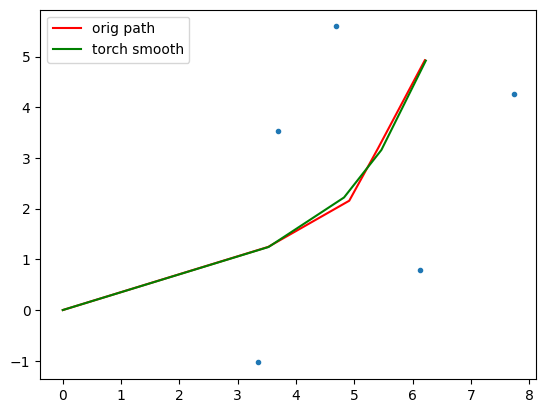

In [16]:
cones = percep_datas[215]
path = david_planner.find_path(cones)
smoother_path,_ = torch_smooth(path)
# smoother_path = david_smooth(path)
stanley_smoother_path = stanley_smooth_path(path)


plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
# plt.plot(stanley_smoother_path[:,0], stanley_smoother_path[:,1], '-', color='orange', label='stanley smooth')
plt.legend()
plt.show()

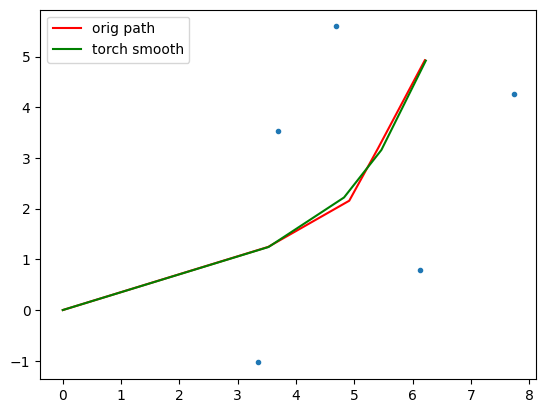

In [17]:
plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
plt.legend()
plt.show()

In [18]:
benchmark_path_planning(find_path_fn=david_planner.find_path, smooth_fn=torch_smooth)

took 1.21 seconds
	Mean time: 4.694 ms
	Max time: 10.334 ms
	Min time: 3.207 ms


In [19]:
def benchmark_path_planning_torch(find_path_fn, smooth_fn=None):
    path_records = []
    indiv_times = []
    start_time = time.time()
    for percep_data in percep_datas:
        curr_start_time = time.time()
        path = find_path_fn(percep_data)
        
        if smooth_fn is not None:
            path, loss = smooth_fn(path)
            path_records.append((path, loss))
            
        curr_end_time = time.time()
        indiv_times.append(curr_end_time - curr_start_time)
    end_time = time.time()
    
    print(f"took {end_time - start_time:.2f} seconds")
    print(f"\tMean time: {((end_time - start_time) / len(percep_datas) * 1000):.3f} ms")
    print(f"\tMax time: {max(indiv_times) * 1000:.3f} ms")
    print(f"\tMin time: {min(indiv_times) * 1000:.3f} ms")
    
    return path_records

In [20]:
path_records = benchmark_path_planning_torch(find_path_fn=david_planner.find_path, smooth_fn=torch_smooth)

took 1.24 seconds
	Mean time: 4.810 ms
	Max time: 10.393 ms
	Min time: 3.095 ms


In [21]:
path_records

[(array([[ 0.        ,  0.        ],
         [ 4.4376445 , -0.43861395],
         [ 5.7678404 , -0.35301933],
         [ 6.8518996 , -0.27075517],
         [ 8.437059  , -0.27486134],
         [10.006408  , -0.34482777],
         [11.682801  , -0.41133994],
         [13.032053  , -0.43034297],
         [14.149141  , -0.42956522]], dtype=float32),
  -111.71459197998047),
 (array([[ 0.        ,  0.        ],
         [ 4.4376445 , -0.43861395],
         [ 5.7678404 , -0.35301933],
         [ 6.8518996 , -0.27075517],
         [ 8.437059  , -0.27486134],
         [10.006408  , -0.34482777],
         [11.682801  , -0.41133994],
         [13.032053  , -0.43034297],
         [14.149141  , -0.42956522]], dtype=float32),
  -111.71459197998047),
 (array([[ 0.        ,  0.        ],
         [ 4.4376445 , -0.43861395],
         [ 5.7678404 , -0.35301933],
         [ 6.8518996 , -0.27075517],
         [ 8.437059  , -0.27486134],
         [10.006408  , -0.34482777],
         [11.682801  , -0.4113

In [22]:
path_records = sorted(path_records, key=lambda x: x[1], reverse=True)

In [23]:
path_records

[(array([[0.       , 0.       ],
         [4.0157566, 1.9545555],
         [5.3236456, 3.33589  ]], dtype=float32),
  -14.99747371673584),
 (array([[0.       , 0.       ],
         [3.9366217, 1.8886179],
         [5.2620893, 3.2532277]], dtype=float32),
  -15.037771224975586),
 (array([[0.       , 0.       ],
         [4.0613575, 2.276534 ],
         [5.500622 , 3.9552586]], dtype=float32),
  -15.044238090515137),
 (array([[0.       , 0.       ],
         [4.0613575, 2.276534 ],
         [5.500622 , 3.9552586]], dtype=float32),
  -15.044238090515137),
 (array([[0.       , 0.       ],
         [3.8188498, 1.7921879],
         [5.170185 , 3.1313941]], dtype=float32),
  -15.096046447753906),
 (array([[0.       , 0.       ],
         [3.9643528, 2.1632898],
         [5.4409156, 3.8095996]], dtype=float32),
  -15.104180335998535),
 (array([[0.       , 0.       ],
         [3.707231 , 1.6820141],
         [5.0888453, 2.9901302]], dtype=float32),
  -15.149801254272461),
 (array([[0.       , 

In [24]:
filter_path_records = [(p, c) for p, c in path_records if p.shape[0] > 5]

In [25]:
filter_path_records

[(array([[0.       , 0.       ],
         [3.6338775, 1.4615242],
         [4.4118304, 2.0875835],
         [5.2310805, 3.1276038],
         [5.7971945, 3.9516246],
         [6.2949095, 4.681791 ]], dtype=float32),
  -62.891197204589844),
 (array([[0.       , 0.       ],
         [3.4923842, 1.3439615],
         [4.285075 , 1.951745 ],
         [5.132589 , 2.9681437],
         [5.721351 , 3.7761178],
         [6.238753 , 4.492473 ]], dtype=float32),
  -62.9465217590332),
 (array([[0.       , 0.       ],
         [3.3459635, 1.238715 ],
         [4.1517262, 1.8295879],
         [5.024805 , 2.8233712],
         [5.6341496, 3.6159167],
         [6.1694174, 4.3190255]], dtype=float32),
  -63.00136947631836),
 (array([[0.       , 0.       ],
         [3.1956394, 1.1393495],
         [4.013769 , 1.7135266],
         [4.9112787, 2.6845477],
         [5.540366 , 3.461489 ],
         [6.0927706, 4.1512194]], dtype=float32),
  -63.05548095703125),
 (array([[0.       , 0.       ],
         [3.976

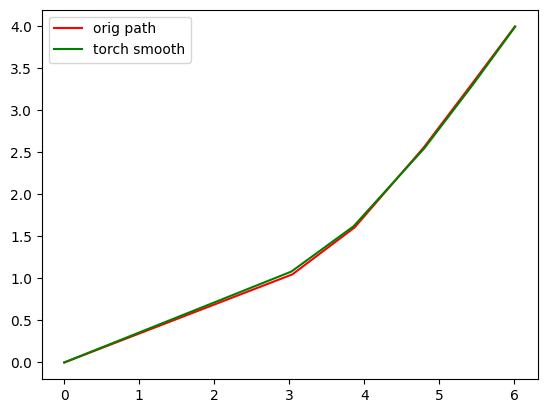

In [26]:
path, c = filter_path_records[5]
# path = david_planner.find_path(cones)
smoother_path, _ = torch_smooth(path)

# plt.plot(cones[:,0], cones[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(smoother_path[:,0], smoother_path[:,1], '-', color='green', label='torch smooth')
plt.legend()
plt.show()

# Experiments

In [44]:
from scipy.optimize import minimize

def normalize(v):
    norm = np.linalg.norm(v,axis=0) + 0.00001
    return v / norm.reshape(1, v.shape[1])

def curvature(waypoints):
    '''
    Curvature as  the sum of the normalized dot product between the way elements
    Implement second term of the smoothing objective.

    args: 
        waypoints [2, num_waypoints] !!!!!
    '''
    shift_left  = np.roll(waypoints, shift=-1, axis=1)
    shift_right = np.roll(waypoints, shift=1,  axis=1)
    left_half   = normalize(shift_left - waypoints)
    right_half  = normalize(waypoints  - shift_right)
    segment     = np.array([np.dot(l, r) for l, r in zip(left_half.T, right_half.T)])
    segment[0]  = 0 # right half of this connects first to last waypoint, delete
    segment[-1] = 0 # left  half of this connects first to last waypoint, delete

    return np.sum(segment)

def smoothing_objective(waypoints, waypoints_center, weight_curvature=16): #weight_curvature=128
    '''
    Objective for path smoothing

    args:
        waypoints [2 * num_waypoints] !!!!!
        waypoints_center [2 * num_waypoints] !!!!!
        weight_curvature (default=40)
    '''
    waypoints = waypoints.reshape(-1, 2)
    waypoints_center = waypoints_center.reshape(-1, 2)
    ls_tocenter = np.sum(np.abs(waypoints_center - waypoints)**2)
    ls_curvature = curvature(waypoints.T)
    boundary_penalty = 0 # ? TODO? F_rddf in Stanley paper     
    return ls_tocenter - weight_curvature * ls_curvature + boundary_penalty

def scipy_smooth(path, enable_constraints):
    constraints_dict = (
        {"type": 'ineq', "fun": lambda x: x[0] - path[0]},
        {"type": 'ineq', "fun": lambda x: x[1] - path[1]},
        {"type": 'ineq', "fun": lambda x: -x[0] + path[0]},
        {"type": 'ineq', "fun": lambda x: -x[1] + path[1]}
    )
    opts = {"maxiter": 1, "disp": False}
    way_points = minimize(smoothing_objective, (path), args=path, options=opts, constraints=constraints_dict if enable_constraints else None)
    smooth_path = way_points["x"]
    smooth_path = smooth_path.reshape(-1, 2)
    smooth_path[0,:] = 0. # TODO:Fix this ?add constraint to minimize?
    return smooth_path, way_points["fun"]

/tmp/ipykernel_627078/1606919041.py:49: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  way_points = minimize(smoothing_objective, (path), args=path, options=opts, constraints=constraints_dict if enable_constraints else None)


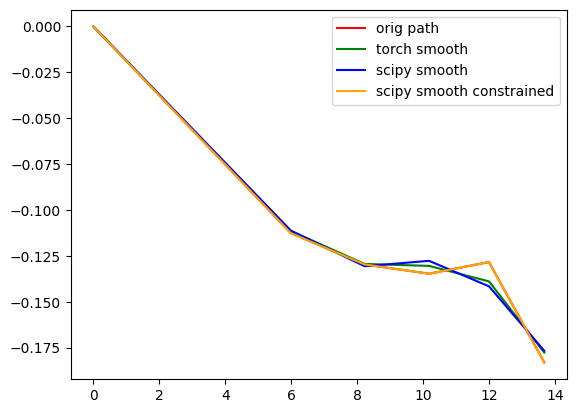

In [50]:
path, c = filter_path_records[30]
# path = david_planner.find_path(cones)
torch_smoother_path,_ = torch_smooth(path)
scipy_smooth_path_constrained,_ = scipy_smooth(path, enable_constraints=True)
scipy_smooth_path,_ = scipy_smooth(path, enable_constraints=False)
# plt.plot(c[:0], c[:,1], '.')
plt.plot(path[:,0], path[:,1], '-', color='red' ,label='orig path')
plt.plot(torch_smoother_path[:,0], torch_smoother_path[:,1], '-', color='green', label='torch smooth')
plt.plot(scipy_smooth_path[:,0], scipy_smooth_path[:,1], '-', color='blue', label='scipy smooth')
plt.plot(scipy_smooth_path_constrained[:,0], scipy_smooth_path_constrained[:,1], '-', color='orange', label='scipy smooth constrained')
plt.legend()
plt.show()